<h1 align='center'> Light Curve Modelling and Physical Parameter Estimation <h1>

## For this section we intend to use the analytical models proposed by Sapir \& Waxman $\href{https://iopscience.iop.org/article/10.3847/1538-4357/aa64df}{2017}$ in order to estimate the physical parameters of ZN-7090

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator

In [2]:
# Load in data from bolometric corrections
data1 = np.load("Layman_B-V.npz")
data2 = np.load("Layman_B-i.npz")
data3 = np.load("Layman_V-i.npz")
# Load interpolated light curves
Bmags, Bmags_err = np.load("Inter_B.npz")['x1'],np.load("Inter_B.npz")['x2']
Vmags, Vmags_err = np.load("Inter_V.npz")['x1'],np.load("Inter_V.npz")['x2']
imags, imgas_err = np.load("Inter_i.npz")['x1'],np.load("Inter_i.npz")['x2']

In [3]:
# Create pandas df for corrections
BC_df = pd.DataFrame()

In [4]:
BC_df["Color"] = ['B - V','B - i','V - i']
BC_df["Type"] = ["BC","BC","BC"]
BC_df["Range"] = [[-0.2, 0.5],[-0.392,2.273],[-0.391,0.658]]
BC_df["C0"] = [-0.393,-0.155,0.181]
BC_df["C1"] = [0.786,-0.450,-0.212]
BC_df["C2"] = [-2.124,-0.167,-1.137]
BC_df["RMS"] = [0.089,0.023,0.044]

In [5]:
BC_df

,Color,Type,Range,C0,C1,C2,RMS
0,B - V,BC,"[-0.2, 0.5]",-0.393,0.786,-2.124,0.089
1,B - i,BC,"[-0.392, 2.273]",-0.155,-0.450,-0.167,0.023
2,V - i,BC,"[-0.391, 0.658]",0.181,-0.212,-1.137,0.044


<h1 align='center'> Layman et al. 2014 B-V<h1>

## Apply Color Smoothening Function to all Bolometric corrections

In [6]:
# Collect specific rows numpy file
dates = data1['t']
mbol = data1['m']
mbol_err = data1['merr']
color = data1['c']
color_err = data1['cerr']
correction = data1['cor']
correction_err = data1['corerr']

In [7]:
# Smoothen color evolution through Monte-Carlo fitting
from Helpers import HO_PolyFit
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)

# Define polynomial of degree 6
def poly_6(x,c0,c1,c2,c3,c4,c5,c6):
    return(c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6)

# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute corresponding bolometric correction terms for colors
def BC_pol(x,c0,c1,c2):
    return(c0 + c1*x + c2*x**2)

In [8]:
# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[0]['C0'],\
                       BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

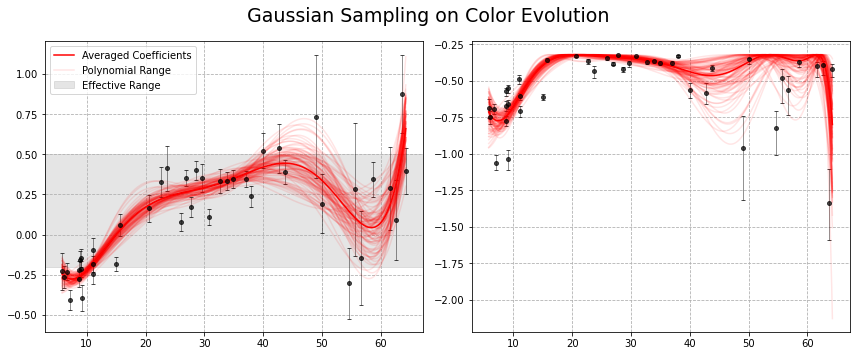

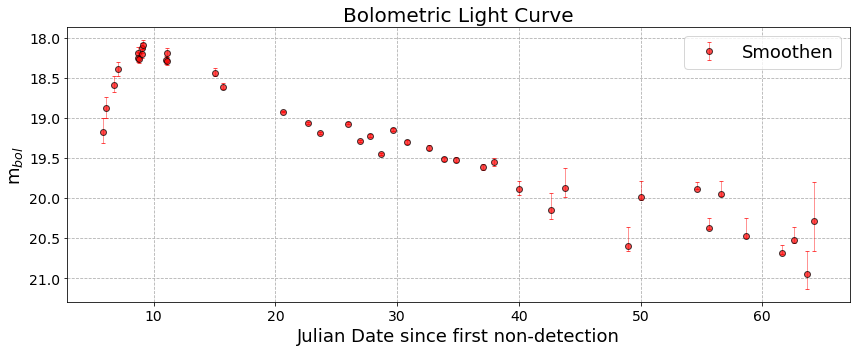

In [9]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),c='r',label="Averaged Coefficients")

a0.axhspan(BC_df.loc[0]['Range'][0], BC_df.loc[0]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
#a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Smoothen')
a0.invert_yaxis()
mbol_BV = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian Date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Save corrected bolometric magntiudes and new error bars
BVm = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags
BVm_err = simulated_err

<h1 align='center'> Layman et al. 2016 B-i <h1>

In [11]:
# Collect specific rows numpy file
dates = data2['t']
mbol = data2['m']
mbol_err = data2['merr']
color = data2['c']
color_err = data2['cerr']
correction = data2['cor']
correction_err = data2['corerr']

In [12]:
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)
# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[1]['C0'],\
                       BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

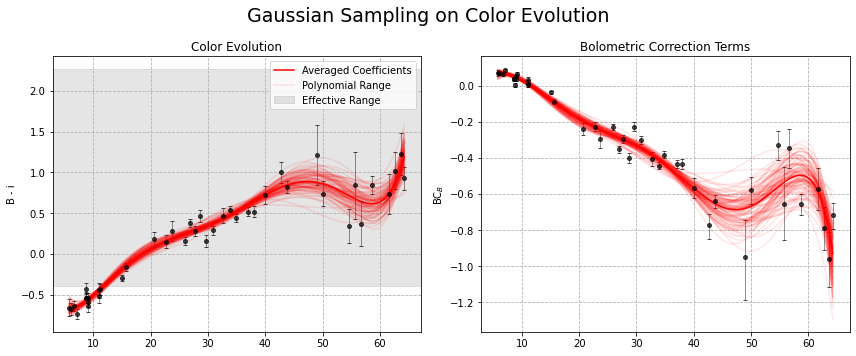

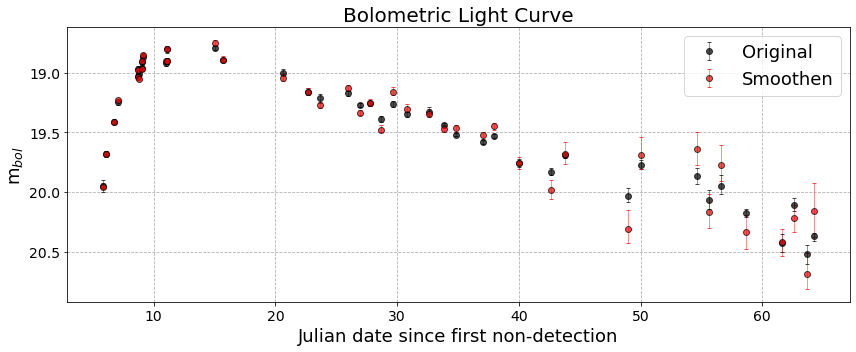

In [13]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),c='r',label="Averaged Coefficients")
a0.set_title("Color Evolution")
a0.set_ylabel("B - i")
a1.set_title("Bolometric Correction Terms")
a1.set_ylabel("BC$_B$")

a0.axhspan(BC_df.loc[1]['Range'][0], BC_df.loc[1]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Smoothen')
a0.invert_yaxis()
mbol_Bi = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
Bim = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags
Bim_err = simulated_err

<h1 align='center'>Layman et al. 2016 V-i <h1>

In [15]:
# Collect specific rows numpy file
dates = data3['t']
mbol = data3['m']
mbol_err = data3['merr']
color = data3['c']
color_err = data3['cerr']
correction = data3['cor']
correction_err = data3['corerr']

In [16]:
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)
# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[2]['C0'],\
                       BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

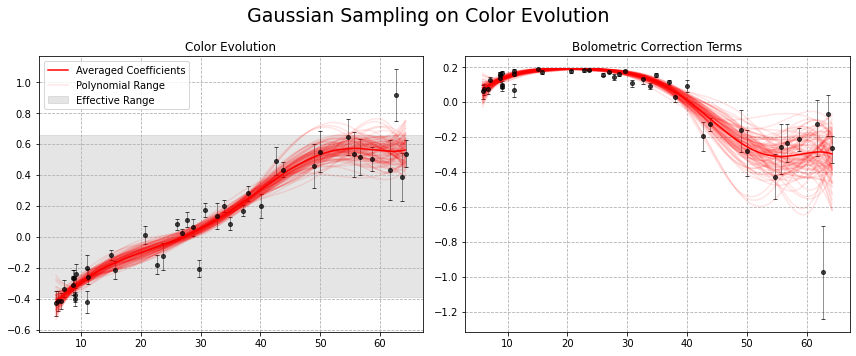

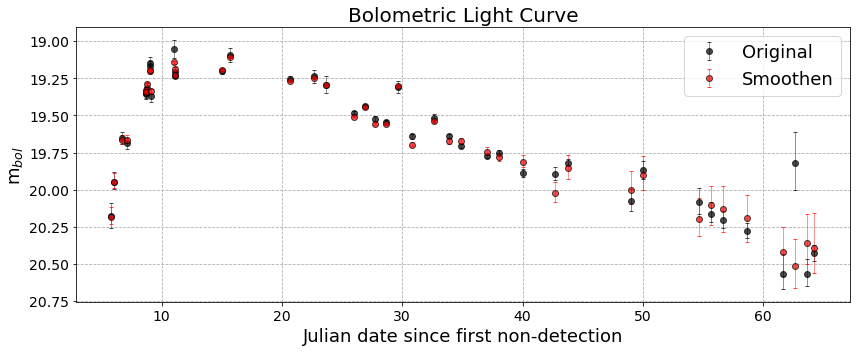

In [17]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),c='r',label="Averaged Coefficients")
a0.set_title("Color Evolution")
a1.set_title("Bolometric Correction Terms")

a0.axhspan(BC_df.loc[2]['Range'][0], BC_df.loc[2]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Smoothen')
a0.invert_yaxis()
mbol_Vi = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
Vim = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags
Vim_err = simulated_err 

<h1 align='center'>Converting to bolometric luminosity using $z=0.1$<h1>

We need to find the comoving distance to the SN which can be found through the following expression

$$
    D_c = \frac{c}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_{M,0}(1+z')^3 + \Omega_{k,0}(1+z')^2 + \Omega_{\Lambda,0}}}
$$

Where the current day accepeted cosmological parameters are

$$
\Omega_{M,0} =  0.3111 \pm 0.0056 \\
\Omega_{k,0} = 0.001 \pm 0.007\\
\Omega_{\Lambda,0} =  0.6889 \pm 0.0056
$$

Values for $\Omega_{M,0}$ and $\Omega_{\Lambda,0}$ obtained from table 2 from Plank mission results $\href{https://arxiv.org/pdf/1807.06209.pdf}{2018}$. While $\Omega_{k,0}$ is calculated through its definition $\Omega_{M,0} + \Omega_{k,0} + \Omega_{\Lambda,0} = 1$ according to Hogg $\href{https://arxiv.org/pdf/astro-ph/9905116v4.pdf}{2020}$

Once we have comoving distance we can compute the luminosity distance as follows

$$
D_L = D_c(1+z)
$$

In [19]:
# Define redshift
z = 0.1

# Define cosmological density parameters
OM = 0.27
OK = 0.00
OL = 0.73

In [20]:
import scipy.integrate as integrate
import astropy.units as u
from astropy.constants import c

# Numerically integrate for the comoving distance at z=0.1
def func(z,M,K,L):
    return(1/np.sqrt(M*(1+z)**3 + K*(1+z)**2 + L))

val = integrate.quad(func,0,z,args=(OM,OK,OL))

# Using H = 67.5 (+/-) 0.5 km/s/Mpc
H = (67.5*u.km/u.s/u.Mpc).to(1/u.s) # 1/s
DC = c/H *val
DL = DC*(1+z)
Dl, Dl_err = DL[0], DL[1]

## Compute absolute bolometric magnitude for each correction using the calculated value for $D_{L}$ using the following expression

$$
M = m - \mathrm{log}_{10}\left(\frac{D_L}{10\, \mathrm{pc}}\right)
$$

From absolute magnitude we can compute the luminosity throug the following relationship 

$$
\frac{L_{bol,*}}{L_{bol,\odot}} = 10^{0.4(M_{bol,\odot} - M_{bol,*})}
$$

Where 

$$
L_{bol,\odot} = 3.845 \times 10^{33}\, \mathrm{erg s^{-1}}\\
M_{bol,\odot} = 4.74 
$$

In [21]:
# Convert from apparent bolometric magntiudes to absolute bolometric magnitudes
BVM = BVm - np.log10(Dl.to(u.pc)/(10*u.pc))
BiM = Bim - np.log10(Dl.to(u.pc)/(10*u.pc))
ViM = Vim - np.log10(Dl.to(u.pc)/(10*u.pc))

# Convert from bolometric absolute magnitude to bolometric luminosity
Lsun = 3.846e33 *u.erg/u.s
Msun = 4.74

# Use the bolometric luminosity calculated through the color evoluion fit
BVL = (Lsun*10**(0.4*(Msun - BVM))).value
BiL = (Lsun*10**(0.4*(Msun - BiM))).value
ViL = (Lsun*10**(0.4*(Msun - ViM))).value

In [22]:
from Bolometric_Corrections import Layman2Luminosity

Lbol1, Lbol_err1 = Layman2Luminosity(Bmags,Vmags,Bmags_err,Vmags_err,BC_df.loc[0]['C0'],\
                                     BC_df.loc[0]['C1'],BC_df.loc[0]['C2'],z)

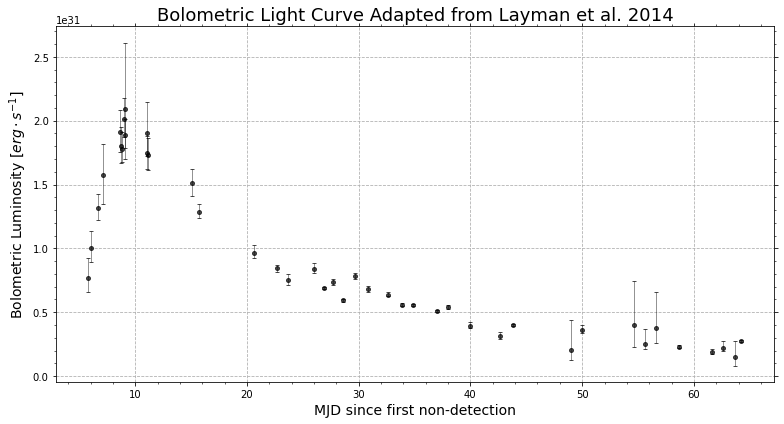

In [23]:
fig, a0 = plt.subplots(figsize=(11,6),ncols=1)
a0.errorbar(dates,BVL,yerr=Lbol_err1,fmt='ko',ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.set_xlabel(f"MJD since first non-detection",fontsize=14)
a0.set_ylabel(r"Bolometric Luminosity [$erg \cdot s^{-1}$]",fontsize=14)
a0.set_title("Bolometric Light Curve Adapted from Layman et al. 2014",fontsize=18)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.1e31))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
plt.tight_layout()